In [1]:
import numpy as np
import random
import pandas as pd
import nltk
import re
import os
import string
import networkx as nx
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
import evaluate

In [2]:
random.seed(111)

# Extractive Summarization

### Preprocessing Functions

In [3]:
#nltk.download('punkt')  # one time execution
stop_words = stopwords.words('english')

In [4]:
def clean(text):
    # normalize characters
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace(' . ', '')
    # remove punctuation, non-ascii characters, and other patterns
    text = re.sub("[^a-zA-Z .]", "", text)

    text = re.sub("(__+)", ' ', str(text)).lower()  # remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', str(text)).lower()  # remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', str(text)).lower()  # remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', str(text)).lower()  # remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', str(text)).lower()  # remove . if it occors more than one time consecutively


    # remove stopwords
    stop = stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in (stop)])

    return text.strip()

In [5]:
def loadGloveModel(gloveFile):
    word_embeddings = {}
    f = open(gloveFile, encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    return word_embeddings


In [6]:
def rem_ascii(s):
    return "".join([c for c in s if ord(c) < 128 ])

### Data

In [7]:
df = pd.read_csv('Data/papers.csv')
df = df[df['abstract'] != 'Abstract Missing'].reset_index()

In [8]:
df['paper_text'] = df['paper_text'].apply(clean)

In [9]:
df = df[df['paper_text'].str.len() < 22000].reset_index()
rand = random.randint(0, len(df))

In [10]:
single_test = df.loc[435, 'paper_text']

In [11]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
nltk.download('punkt') 
glove_path = 'Data/Glove/glove.6B.100d.txt'
dim = 100 ## depends on Glove embeddings dimension

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\epaul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Embeddings with GloVe

In [12]:
word_embeddings = loadGloveModel(glove_path)

In [13]:
sentences = sent_tokenize(single_test)
cleaned_texts = [rem_ascii(clean(sentence)) for sentence in sentences]

In [14]:
sentence_vectors = []
for i in cleaned_texts:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((dim,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((dim,))
    sentence_vectors.append(v)

### Similarity matrix of all sentences in text

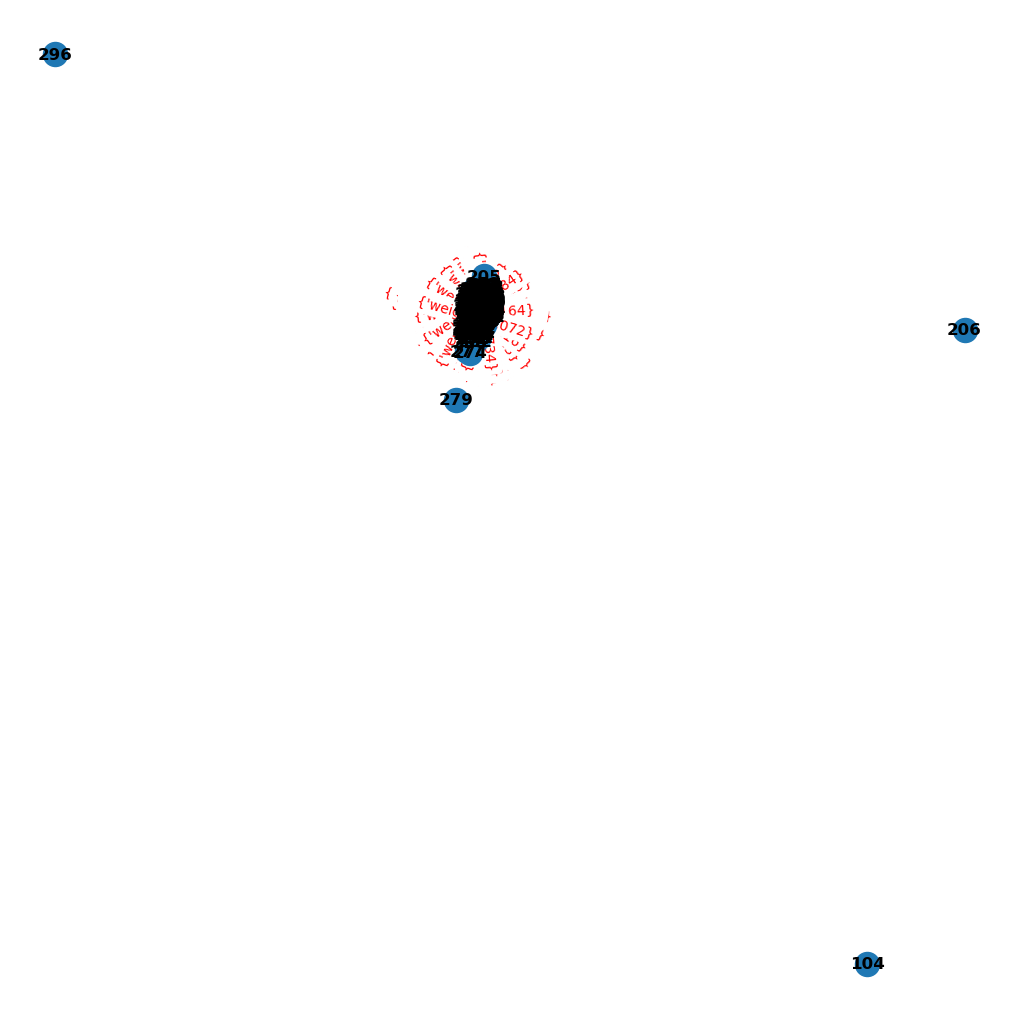

In [15]:
sim_mat = np.zeros([len(cleaned_texts), len(cleaned_texts)])
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,dim),sentence_vectors[j].reshape(1,dim))[0,0]
            
sim_mat = np.round(sim_mat,3)


# Creating the network graph
nx_graph = nx.from_numpy_array(sim_mat)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
plt.show()


### TextRank Algorithm
##### picking most 'important' and encaptuirng sentences

In [16]:
scores = nx.pagerank(nx_graph)
print(scores)

{0: 0.003227641522791975, 1: 0.0032685709874593393, 2: 0.0032310088738470213, 3: 0.003025339414566389, 4: 0.003428618909042235, 5: 0.003314103857730416, 6: 0.0029352178283978546, 7: 0.003057842066733995, 8: 0.0028367491813743135, 9: 0.0033470760718827854, 10: 0.003412306949168158, 11: 0.0032847847490719883, 12: 0.0035020539718709745, 13: 0.0033139472234174007, 14: 0.0025992154484721502, 15: 0.0029257412936551834, 16: 0.003026999898973469, 17: 0.003314736610085718, 18: 0.002788327804821722, 19: 0.0034935862274122573, 20: 0.0032640141969140293, 21: 0.0032388633611971033, 22: 0.003417766298402439, 23: 0.0033142608441991852, 24: 0.0033777080227299344, 25: 0.0027720607072022887, 26: 0.003334944700003496, 27: 0.0034413835090092524, 28: 0.0034309356674599553, 29: 0.0033636478653471, 30: 0.0031547149320318795, 31: 0.0030640316430096516, 32: 0.0034256692320312767, 33: 0.0035094408844921297, 34: 0.003247931651413164, 35: 0.003293378738753661, 36: 0.003252833032329882, 37: 0.0028795748481783116, 

In [17]:
ranked_sentences = sorted(((scores[i],i) for i,s in enumerate(sentences)), reverse=True)
arranged_sentences = sorted(ranked_sentences[0:6], key=lambda x:x[1])
print("\n".join([sentences[x[1]] for x in arranged_sentences]))

ca cb p constants determined according specific model architecture reccurent network set ca cb since affect qualitative model.
b task setting choice probability yields matching behavior denoted pmatch pmatch figure ad plots evolution choice probability order parameters two learning rules without weight normalization constraint.
contrast first order terms appear .
figure evolution choice probability various learning rates .
rmhebb rule without normalization networks approach matching behavior even large learning rate .
learning rate increases choice probabilities deviate matching behavior towards unbiased random choice pa b plot rmrule hard bound condition synaptic weights restricted interval jmax n jmax .


In [18]:
pred = [" ".join([sentences[x[1]] for x in arranged_sentences])]

In [19]:
rouge = evaluate.load('rouge')

Using the latest cached version of the module from C:\Users\epaul\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--rouge\b01e0accf3bd6dd24839b769a5fda24e14995071570870922c71970b3a6ed886 (last modified on Wed Apr  3 18:26:54 2024) since it couldn't be found locally at evaluate-metric--rouge, or remotely on the Hugging Face Hub.


In [20]:
results = rouge.compute(predictions=[clean(pred[0])], references=[clean(df.loc[rand, 'abstract'])])
print(results)

{'rouge1': 0.13930348258706465, 'rouge2': 0.030150753768844223, 'rougeL': 0.09950248756218906, 'rougeLsum': 0.09950248756218906}


### Full dataset

In [21]:
score = 0
max_score = 0
p_id = 0
for paper in range(250):
    sentences = sent_tokenize(df.loc[paper, 'paper_text'])
    cleaned_texts = [rem_ascii(clean(sentence)) for sentence in sentences]
    sentence_vectors = []
    for i in cleaned_texts:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((dim,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((dim,))
        sentence_vectors.append(v)
    sim_mat = np.zeros([len(cleaned_texts), len(cleaned_texts)])
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,dim),sentence_vectors[j].reshape(1,dim))[0,0]
            
    sim_mat = np.round(sim_mat,3)

    # Creating the network graph
    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph, max_iter=1500)
    ranked_sentences = sorted(((scores[i],i) for i,s in enumerate(sentences)), reverse=True)
    arranged_sentences = sorted(ranked_sentences[0:6], key=lambda x:x[1])
    pred = [" ".join([sentences[x[1]] for x in arranged_sentences])]
    score += rouge.compute(predictions=[clean(pred[0])], references=[clean(df.loc[paper, 'abstract'])])['rouge1']
    if score >= max_score:
        ma_score = score
        p_id = paper
    print(paper)
print(f'avg rouge1 score for GloVe embedding is {score/len(df)}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 1500 iterations')